<a href="https://colab.research.google.com/github/codernayeem/food101-blog/blob/main/notebooks/food101_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FOOD101 Blog (101 classes of Food Classificaion)

we are going to use **TensorFlow v2.4.2**, **EfficientNetB0** and the **food101** dataset from tensorflow datasets (**TFDS**)

## Getting Started

In [1]:
# to make sure efficientnet works fine (as tf v2.5.0 has some bugs)
!pip -q install tensorflow==2.4.2

     |████████████████████████████████| 394.5 MB 31 kB/s 
     |████████████████████████████████| 3.8 MB 50.2 MB/s 
     |████████████████████████████████| 462 kB 53.6 MB/s 
     |████████████████████████████████| 2.9 MB 33.2 MB/s 


In [2]:
# imports
import numpy as np
import pandas as pd
import os, json
from os.path import join

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
# checking GPU & TensorFlow version
!nvidia-smi -L
print(tf.__version__) 

GPU 0: Tesla T4 (UUID: GPU-5a2af33b-7c5a-436a-98a9-1084e1621912)
2.4.2


In [4]:
# helper module 'utils.py' from @codernayeem/dl-practice
!wget https://raw.githubusercontent.com/codernayeem/dl-practice/main/utils.py
import utils

--2021-07-20 11:44:08--  https://raw.githubusercontent.com/codernayeem/dl-practice/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19239 (19K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  18.79K  --.-KB/s    in 0s      

2021-07-20 11:44:09 (103 MB/s) - ‘utils.py’ saved [19239/19239]



In [5]:
# mount Google Drive for use later
utils.mount_gdrive()
gdrive_path = "/content/drive/MyDrive/Saved_Models/food101_blog/v1_efficientnetb0"
 
# creating folder for this project if not exists
utils.create_dir(gdrive_path)

Mounted at /content/drive


In [6]:
# set mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


## Imporing our dataset using `TFDS` and Explore

In [7]:
import tensorflow_datasets as tfds

# List available datasets
all_datasets = tfds.list_builders()
print("food101" in all_datasets)

True


In [8]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete6UO3E4/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete6UO3E4/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [9]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [10]:
# Get class names
class_names = ds_info.features["label"].names
num_classes = len(class_names)
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [11]:
for image, label in train_data.take(1):
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}""")


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 24
  Class name (str form): clam_chowder


/content/utils.py:249: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  imgs = np.array(list(imgs))


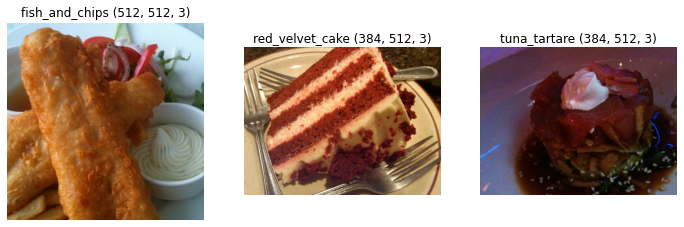

In [12]:
# Visualize
# sample = [], []
# for image, label in train_data.take(3):
#   sample[0].append(image)
#   sample[1].append(label)
utils.plot_images(train_data.take(3), as_tuple=True, class_names=class_names, show_shape=True)

## Preprocess our images

We need to process our images
<table>
  <tr>
    <td></td>
    <td> <b> Current Images </b> </td>
    <td> <b> Needs </b> </td>
    <td> <b> methods/step </b> </td>
  </tr>
  <tr>
    <td> dtype </td>
    <td> uint8 </td>
    <td> float32 </td>
    <td> tf.cast </td>
  </tr>
  <tr>
    <td> image shape </td>
    <td> different sized images </td>
    <td> (240, 240, 3) </td>
    <td> tf.image.resize </td>
  </tr>
  <tr>
    <td> Normalization (not for EfficientNet) </td>
    <td> Not scaled  </td>
    <td> Scaled (values between 0 & 1) </td>
    <td> tf.keras.layers.experimental.preprocessing.Rescaling </td>
  </tr>
</table>

In [13]:
# Let's define some important things first
BATCH_SIZE = 32
IMAGE_SHAPE = (224, 224) # for EfficientNetB0

In [14]:
# preprocessing image function
def preprocess_img(image, label):
  image = tf.image.resize(image, IMAGE_SHAPE) # reshape to img_shape
  return tf.cast(image, tf.float32), label

(512, 512, 3) <dtype: 'uint8'>
(224, 224, 3) <dtype: 'float32'>


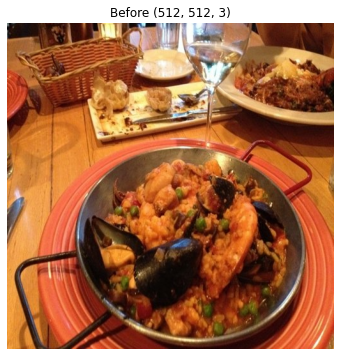

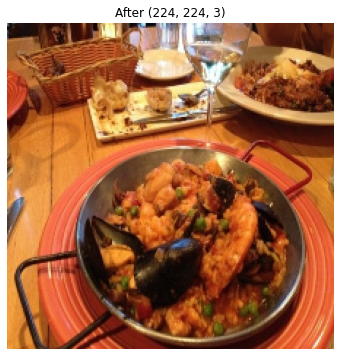

In [15]:
# check if our function working fine
for image, label in train_data.take(1):
  preprocessed_img = preprocess_img(image, label)[0]
  print(image.shape, image.dtype)
  print(preprocessed_img.shape, preprocessed_img.dtype)
  utils.plot_image(image, 'Before', show_shape=True)
  utils.plot_image(preprocessed_img, 'After', rescale=1/255, show_shape=True)

Our preprocessing steps will be :
  * map()
  * cache()
  * shuffle()
  * batch()
  * prefetch()

In [16]:
train_data = train_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=1000)
train_data = train_data.batch(batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
 
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=1000)
test_data = test_data.batch(batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

We are good to go

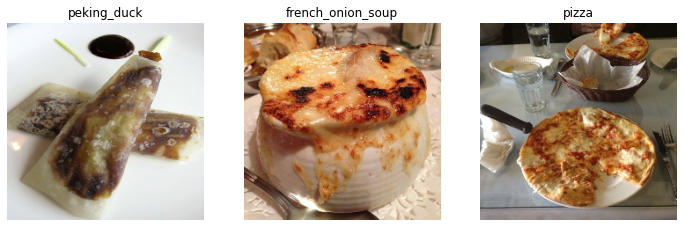

In [18]:
# Again Visualize
for images, labels in train_data.take(1):
  utils.plot_images(images[:3], labels[:3],
                    class_names=class_names,
                    rescale=1/255)

## Building Model

### Prepare our Models roadmap
* Create A **Feature Extraction** Model using **EfficientNetB0**
* **Fine Tune** the **Feature Extraction** Model

### Feature Extraction with EfficientNetB0

In [19]:
# creating data augmentation layer
data_aug_layer = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
], name ="data_augmentation_layer")

In [20]:
# Creating Feature Extraction Model using EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
 
inputs = layers.Input(shape=(*IMAGE_SHAPE, 3), name="input_layer")
x = data_aug_layer(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = layers.Dense(num_classes, name="dense_layer")(x)
outputs = layers.Activation('softmax', dtype='float32', name='output_layer')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])
model.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
dense_layer (Dense)          (None, 101)               129381    
_________________________________________________________________
output_layer (Activation)    (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainabl

Let's create a `ModelCheckPoint` and `EarlyStopping` Callback

In [21]:
# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_path = "checkpoints/feature_extraction_model/checkpoint.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_loss",
                                                         save_best_only=True,
                                                         save_freq="epoch",
                                                         verbose=1)

# if val_loss increases for 3 epochs in a row, stop training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

In [22]:
history_1 = model.fit(train_data,
                      epochs=50, # maximum 50 epochs
                      callbacks=[utils.create_tensorboard_callback('training_logs', 'feature_extraction_model'),
                                checkpoint_callback,
                                early_stopping],
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=len(test_data))

Saving TensorBoard log files to: training_logs/feature_extraction_model/20210720-115613
Epoch 1/50
2368/2368 [==============================] - 307s 114ms/step - loss: 2.7077 - accuracy: 0.3795 - val_loss: 1.4357 - val_accuracy: 0.6198

Epoch 00001: val_loss improved from inf to 1.43572, saving model to checkpoints/feature_extraction_model/checkpoint.ckpt
Epoch 2/50
2368/2368 [==============================] - 235s 99ms/step - loss: 1.7661 - accuracy: 0.5560 - val_loss: 1.3110 - val_accuracy: 0.6513

Epoch 00002: val_loss improved from 1.43572 to 1.31103, saving model to checkpoints/feature_extraction_model/checkpoint.ckpt
Epoch 3/50
2368/2368 [==============================] - 219s 92ms/step - loss: 1.6209 - accuracy: 0.5883 - val_loss: 1.2738 - val_accuracy: 0.6566

Epoch 00003: val_loss improved from 1.31103 to 1.27385, saving model to checkpoints/feature_extraction_model/checkpoint.ckpt
Epoch 4/50
2368/2368 [==============================] - 218s 91ms/step - loss: 1.5428 - accuracy

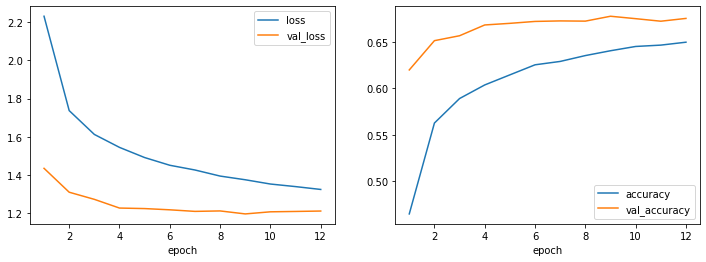

In [23]:
utils.plot_history(history_1)

In [24]:
model.evaluate(test_data)

790/790 [==============================] - 54s 67ms/step - loss: 1.2128 - accuracy: 0.6752


[1.212816834449768, 0.6752475500106812]

In [25]:
# Load checkpoint weights (best weights) and evaluate model
model.load_weights(checkpoint_path)
model.evaluate(test_data)

790/790 [==============================] - 54s 66ms/step - loss: 1.1978 - accuracy: 0.6776


[1.1978086233139038, 0.677584171295166]

In [26]:
# Saving model
model_path = 'feature_extraction_model'
model.save(model_path)

INFO:tensorflow:Assets written to: feature_extraction_model/assets


INFO:tensorflow:Assets written to: feature_extraction_model/assets


In [27]:
# Saved Model
utils.copytree(model_path, join(gdrive_path, model_path))

# TensorBoard Logs
utils.copytree("training_logs", join(gdrive_path, "training_logs"))

So, we got 67.75% accuracy on feature extraction model. Let's Fine Tune to improve our model

### Fine Tune the Feature Extraction Model

In [28]:
# copy and load saved model from gdrive (if needed)
 
# utils.copytree(join(gdrive_path, "feature_extraction_model"), "feature_extraction_model")
# model = tf.keras.models.load_model('feature_extraction_model')

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
dense_layer (Dense)          (None, 101)               129381    
_________________________________________________________________
output_layer (Activation)    (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

In [30]:
# Lets check which layers are trainable in feature_extraction_model
layers = [(l.name, l.trainable, l.dtype, l.dtype_policy) for l in model.layers]
pd.DataFrame(layers, columns=['name', 'trainable', 'dtype', 'dtype_policy'])

,name,trainable,dtype,dtype_policy
0,input_layer,True,float32,"<Policy ""float32"">"
1,data_augmentation_layer,True,float32,"<Policy ""mixed_float16"">"
2,efficientnetb0,False,float32,"<Policy ""mixed_float16"">"
3,global_average_pooling_layer,True,float32,"<Policy ""mixed_float16"">"
4,dense_layer,True,float32,"<Policy ""mixed_float16"">"
5,output_layer,True,float32,"<Policy ""float32"">"


In [31]:
print('Trainable layers in base model :') # (EfficentNetB0)
layers = [(l.name, l.trainable, l.dtype, l.dtype_policy) for l in model.layers[2].layers if l.trainable]
pd.DataFrame(layers, columns=['name', 'trainable', 'dtype', 'dtype_policy'])

Trainable layers in base model :


,name,trainable,dtype,dtype_policy


Let's unfreeeze the whole base model for fine tuning

In [32]:
# unfreeze all layers of the base model
model.layers[2].trainable = True
 
# compile with lower lr than default for fine-tuning
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
dense_layer (Dense)          (None, 101)               129381    
_________________________________________________________________
output_layer (Activation)    (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
______________________________________________

In [33]:
# Create checkpoint callback
checkpoint_path = "checkpoints/fine_tuned_model/checkpoints.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_loss",
                                                         save_best_only=True,
                                                         save_freq="epoch",
                                                         verbose=1)

# if val_loss increases for 5 epochs in a row, stop training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=5) 

# Creating lr reduction callback (multiply the learning rate by 0.2 [reduce by 5x])
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-8)

In [34]:
history_2 = model.fit(train_data,
                      epochs=50, # maximum 50 epochs
                      callbacks=[utils.create_tensorboard_callback('training_logs', 'fine_tuned_model'),
                                  checkpoint_callback,
                                  early_stopping,
                                  reduce_lr],
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=len(test_data))

Saving TensorBoard log files to: training_logs/fine_tuned_model/20210720-124409
Epoch 1/50
2368/2368 [==============================] - 594s 244ms/step - loss: 1.2446 - accuracy: 0.6718 - val_loss: 1.0250 - val_accuracy: 0.7205

Epoch 00001: val_loss improved from inf to 1.02505, saving model to checkpoints/fine_tuned_model/checkpoints.ckpt
Epoch 2/50
2368/2368 [==============================] - 408s 171ms/step - loss: 0.9276 - accuracy: 0.7493 - val_loss: 0.9041 - val_accuracy: 0.7501

Epoch 00002: val_loss improved from 1.02505 to 0.90411, saving model to checkpoints/fine_tuned_model/checkpoints.ckpt
Epoch 3/50
2368/2368 [==============================] - 374s 157ms/step - loss: 0.7613 - accuracy: 0.7893 - val_loss: 0.8837 - val_accuracy: 0.7643

Epoch 00003: val_loss improved from 0.90411 to 0.88372, saving model to checkpoints/fine_tuned_model/checkpoints.ckpt
Epoch 4/50
2368/2368 [==============================] - 363s 153ms/step - loss: 0.6376 - accuracy: 0.8192 - val_loss: 0.958

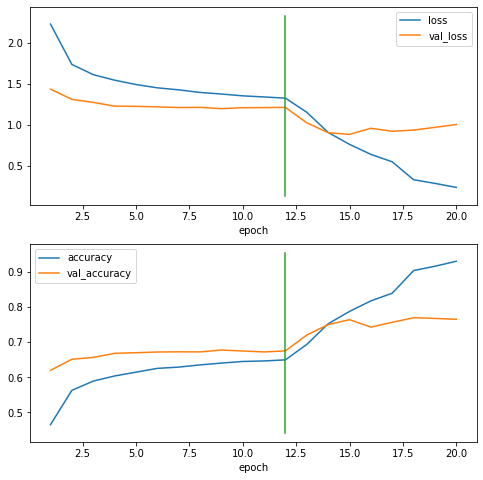

In [35]:
# utils.plot_history(history_2)
utils.compare_histories(history_1, history_2)

In [36]:
model.evaluate(test_data)

790/790 [==============================] - 53s 65ms/step - loss: 1.0040 - accuracy: 0.7655


[1.0040079355239868, 0.7654653191566467]

In [37]:
# Load checkpoint weights (best weights) and evaluate model
model.load_weights(checkpoint_path)
model.evaluate(test_data)

790/790 [==============================] - 53s 65ms/step - loss: 0.8837 - accuracy: 0.7643


[0.8837165832519531, 0.7643168568611145]

Well, we got almost 76.5% accuracy (increased from 67.75%) after fine tuning

In [38]:
# Saving model
model_path = 'fine_tuned_model'
model.save(model_path)

INFO:tensorflow:Assets written to: fine_tuned_model/assets


INFO:tensorflow:Assets written to: fine_tuned_model/assets


In [39]:
# Saved Model
utils.copytree(model_path, join(gdrive_path, model_path))

# TensorBoard Logs
utils.copytree("training_logs", join(gdrive_path, "training_logs"))

## Saving Things

We got our model (**fine_tuned_model with all layers unfrozen**). we saved them and uploaded to google drive for later use. We, also need to save some details.

In [40]:
# saving class name and copying to gdrive
data = {
    "class_names" : class_names,
    "image_shape" : IMAGE_SHAPE,
    "tf_version" : tf.__version__,
}

with open('data.json', 'w') as fl:
    json.dump(data, fl)

utils.copy("data.json", gdrive_path)

'/content/drive/MyDrive/Saved_Models/food101_blog/v1_efficientnetb0/data.json'

## Testing Our Model

In [41]:
# copy and load saved model from gdrive (if needed)
 
# utils.copytree(join(gdrive_path, "fine_tuned_model"), "fine_tuned_model")
# model = tf.keras.models.load_model('fine_tuned_model')
 
# utils.copy(join(gdrive_path, "data.json"), "data.json")
# with open('data.json', 'r') as fl:
#     data = json.load(fl)
# class_names = data['class_names']
# IMAGE_SHAPE = data['image_shape']

In [42]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
dense_layer (Dense)          (None, 101)               129381    
_________________________________________________________________
output_layer (Activation)    (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
______________________________________________

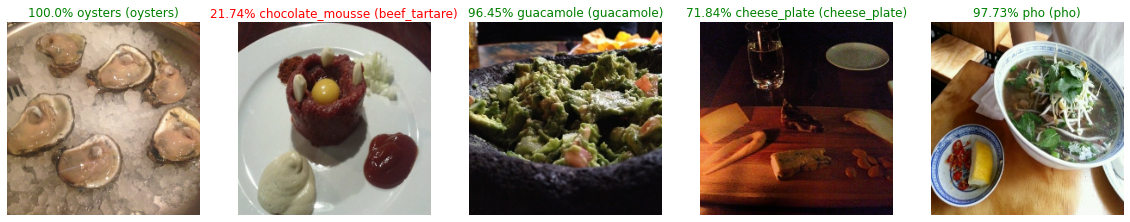

In [64]:
for imgs, labels in test_data.take(1): # take the one batch with 32 images and labels
  utils.plot_pred_images(imgs[:5], model.predict(imgs[:5]), labels[:5],
                         class_names=class_names, rescale=1/255)

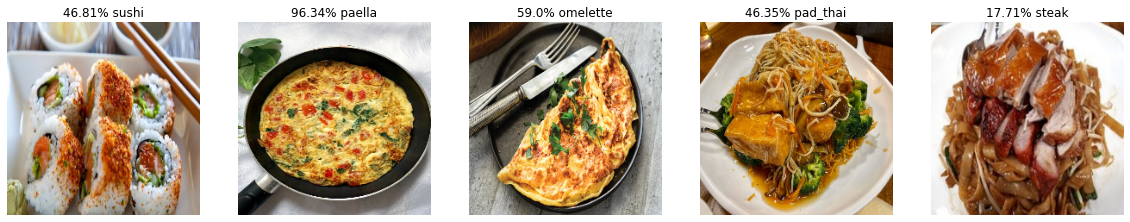

In [63]:
imgs = [
        'https://i.ndtvimg.com/i/2016-01/sushi-625_625x350_71452771735.jpg',
        'https://i2.wp.com/mygorgeousrecipes.com/wp-content/uploads/2016/01/Omelette-a.jpg',
        'https://media.healthyfood.com/wp-content/uploads/2018/02/Basic-omelette-1024x656.jpg',
        'https://media-cdn.tripadvisor.com/media/photo-s/19/81/a2/70/very-authentic-and-really.jpg',
        'https://media-cdn.tripadvisor.com/media/photo-f/19/c3/99/51/manchester-chinese-restaurant.jpg',
      ]
imgs = utils.download_images(imgs, image_shape=IMAGE_SHAPE)
pred = model.predict(imgs)
utils.plot_pred_images(imgs, pred, class_names=class_names)

All right! Looks all good.

 ## Discuss our Model

In [45]:
# getting our y_test and y_pred in 'int' mode 
# so that we can do things easily
y_test = []
y_pred = []
for img, label in test_data.unbatch():
  y_test.append(label.numpy())
  pred = model.predict(tf.expand_dims(img, axis=0)).squeeze()
  y_pred.append(tf.argmax(pred, axis=0).numpy())

In [46]:
len(y_test), len(y_pred)

(25250, 25250)

In [47]:
print(y_test[:10])
print(y_pred[:10])

[27, 30, 97, 73, 53, 39, 78, 19, 53, 72]
[27, 69, 97, 73, 53, 39, 78, 19, 53, 42]


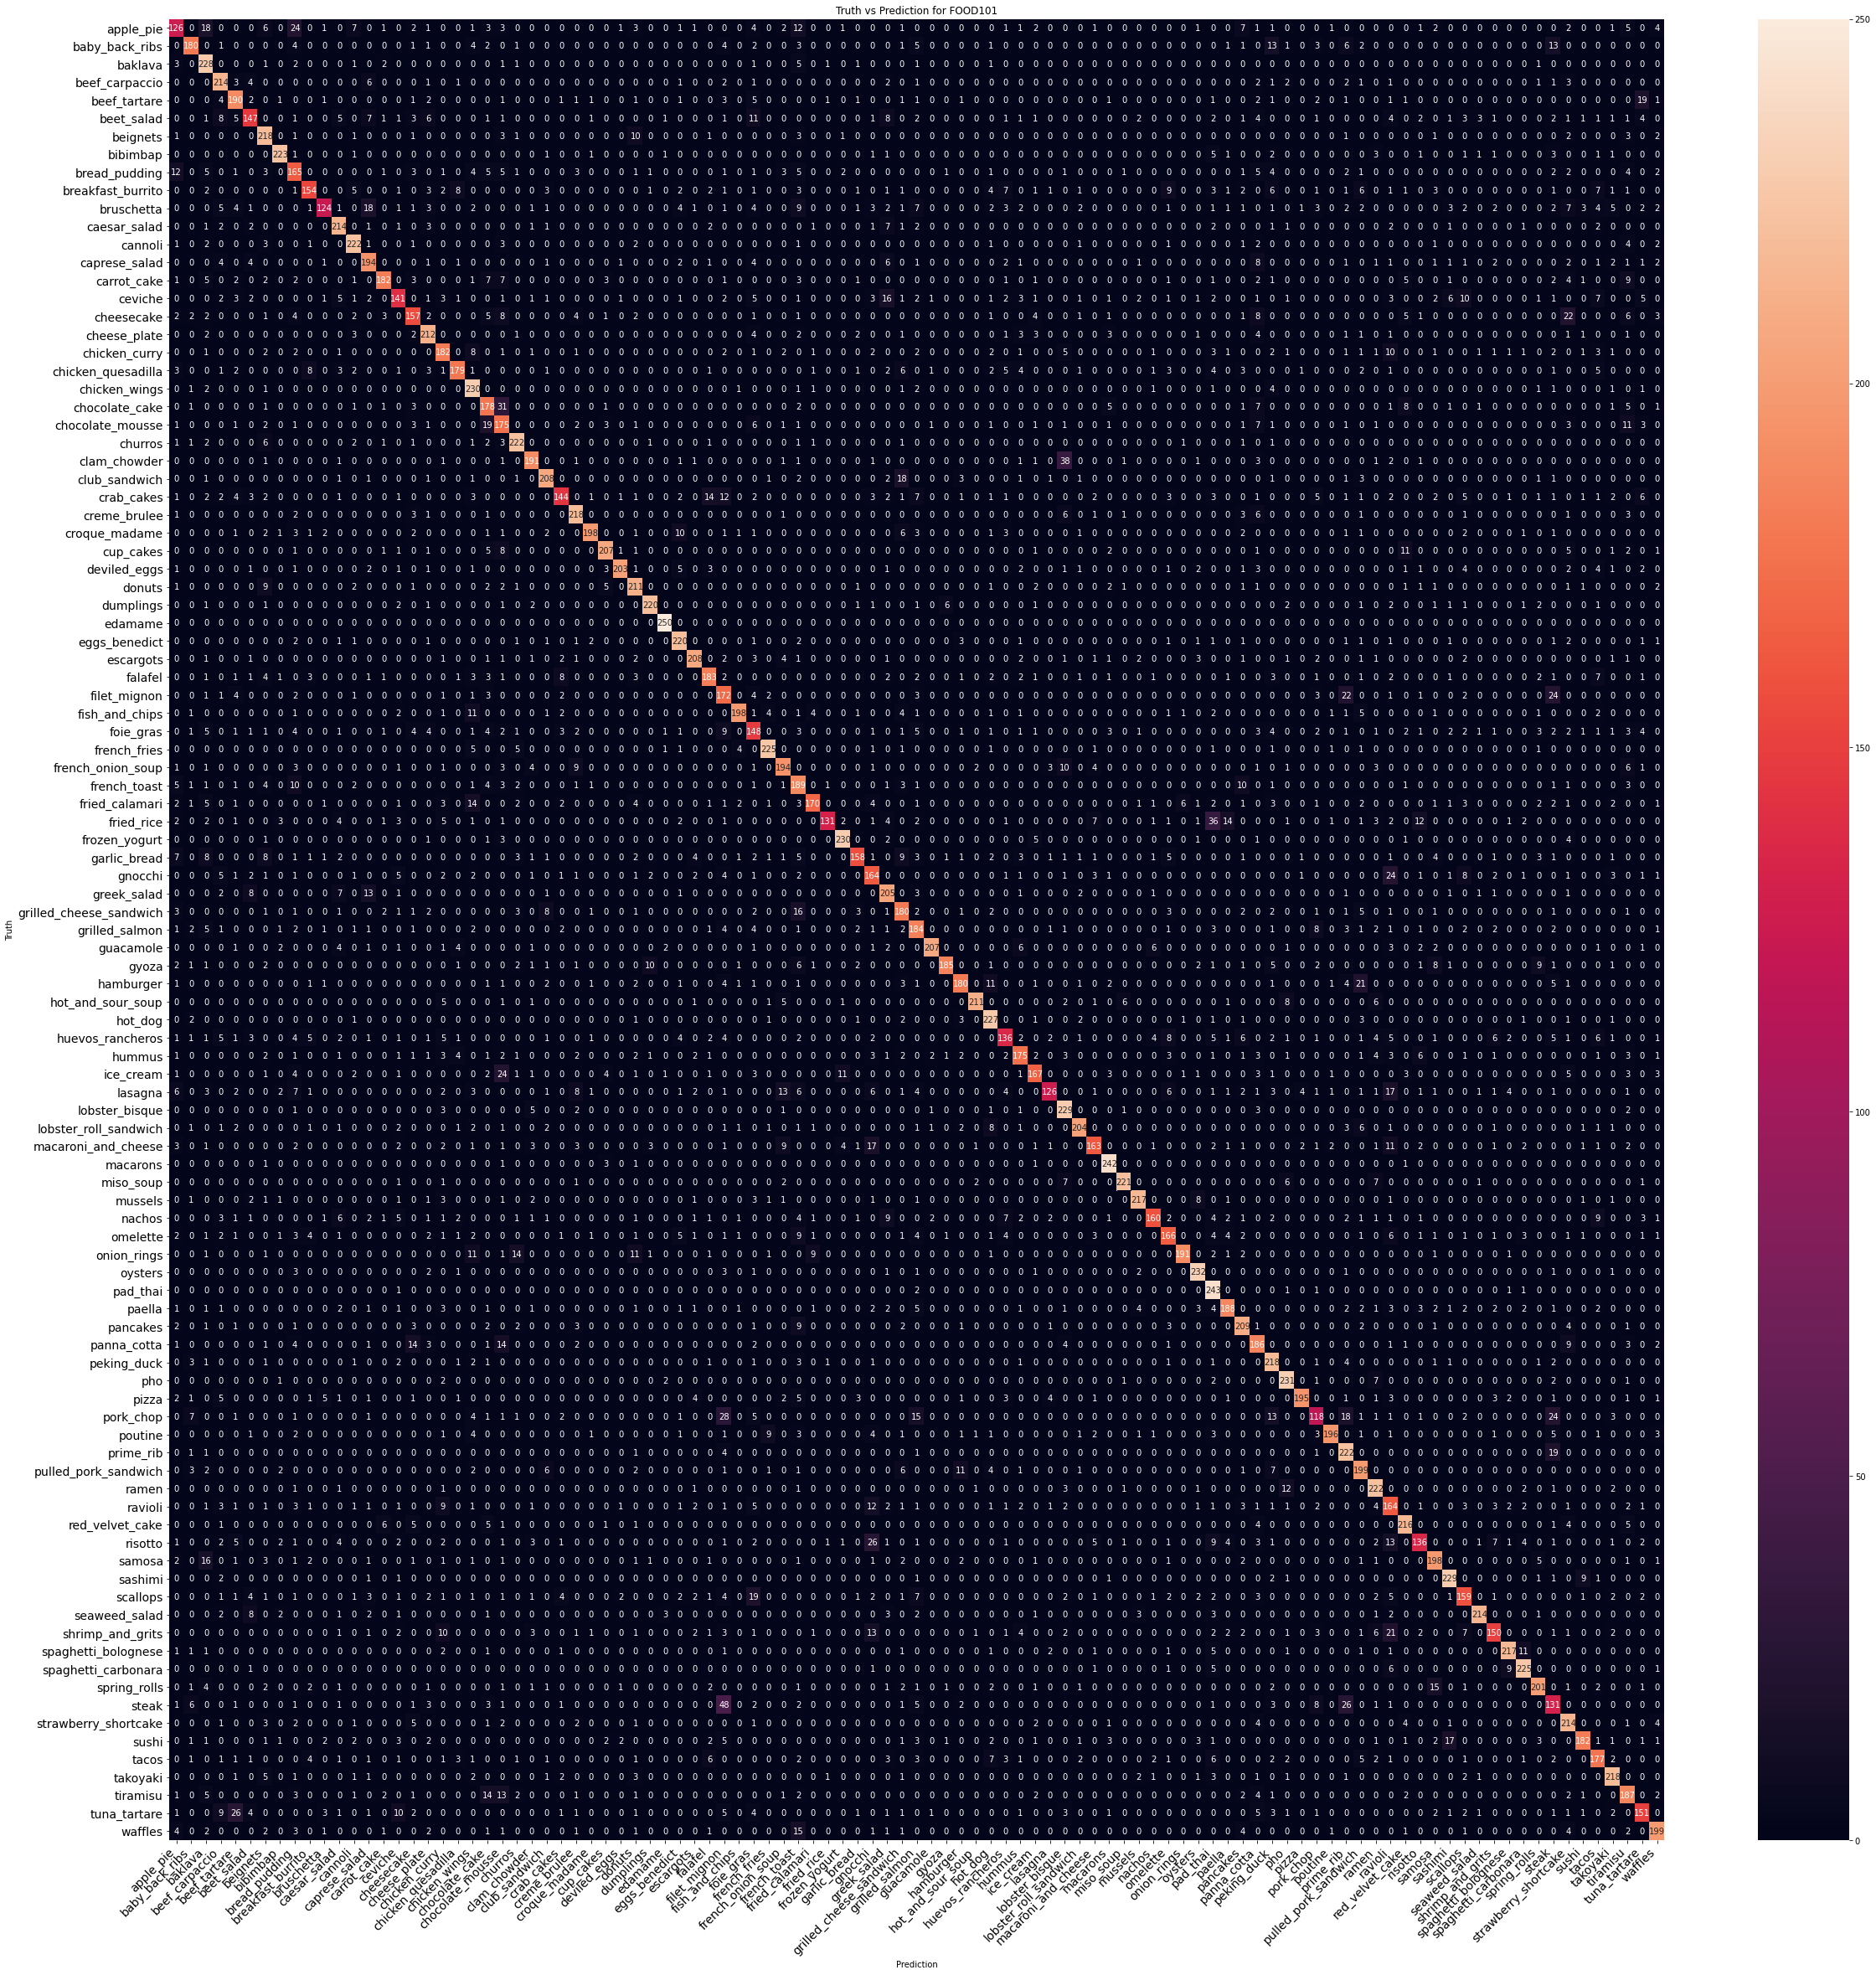

In [61]:
# plot a confusion metrics
utils.plot_confusion_matrix(y_test, y_pred, class_names=class_names, figsize=(40, 40), title="Truth vs Prediction for FOOD101")

Let's look at the F1 scores for these classes

In [49]:
from sklearn.metrics import classification_report, f1_score

In [50]:
print(classification_report(y_test, y_pred, target_names=class_names))

                         precision    recall  f1-score   support

              apple_pie       0.60      0.50      0.55       250
         baby_back_ribs       0.81      0.72      0.76       250
                baklava       0.65      0.91      0.76       250
         beef_carpaccio       0.74      0.86      0.79       250
           beef_tartare       0.70      0.76      0.73       250
             beet_salad       0.72      0.59      0.65       250
               beignets       0.71      0.87      0.78       250
               bibimbap       0.91      0.89      0.90       250
          bread_pudding       0.57      0.66      0.61       250
      breakfast_burrito       0.81      0.62      0.70       250
             bruschetta       0.85      0.50      0.63       250
           caesar_salad       0.77      0.86      0.81       250
                cannoli       0.83      0.89      0.86       250
          caprese_salad       0.73      0.78      0.75       250
            carrot_cake 

Let's plot a barchart for F1 scores

In [51]:
f1_scores = pd.Series(np.round(f1_score(y_test, y_pred, average=None), 2), index=class_names).sort_values()
f1_scores

steak            0.50
apple_pie        0.55
pork_chop        0.55
ravioli          0.56
foie_gras        0.56
                 ... 
bibimbap         0.90
frozen_yogurt    0.91
miso_soup        0.91
macarons         0.92
edamame          0.98
Length: 101, dtype: float64

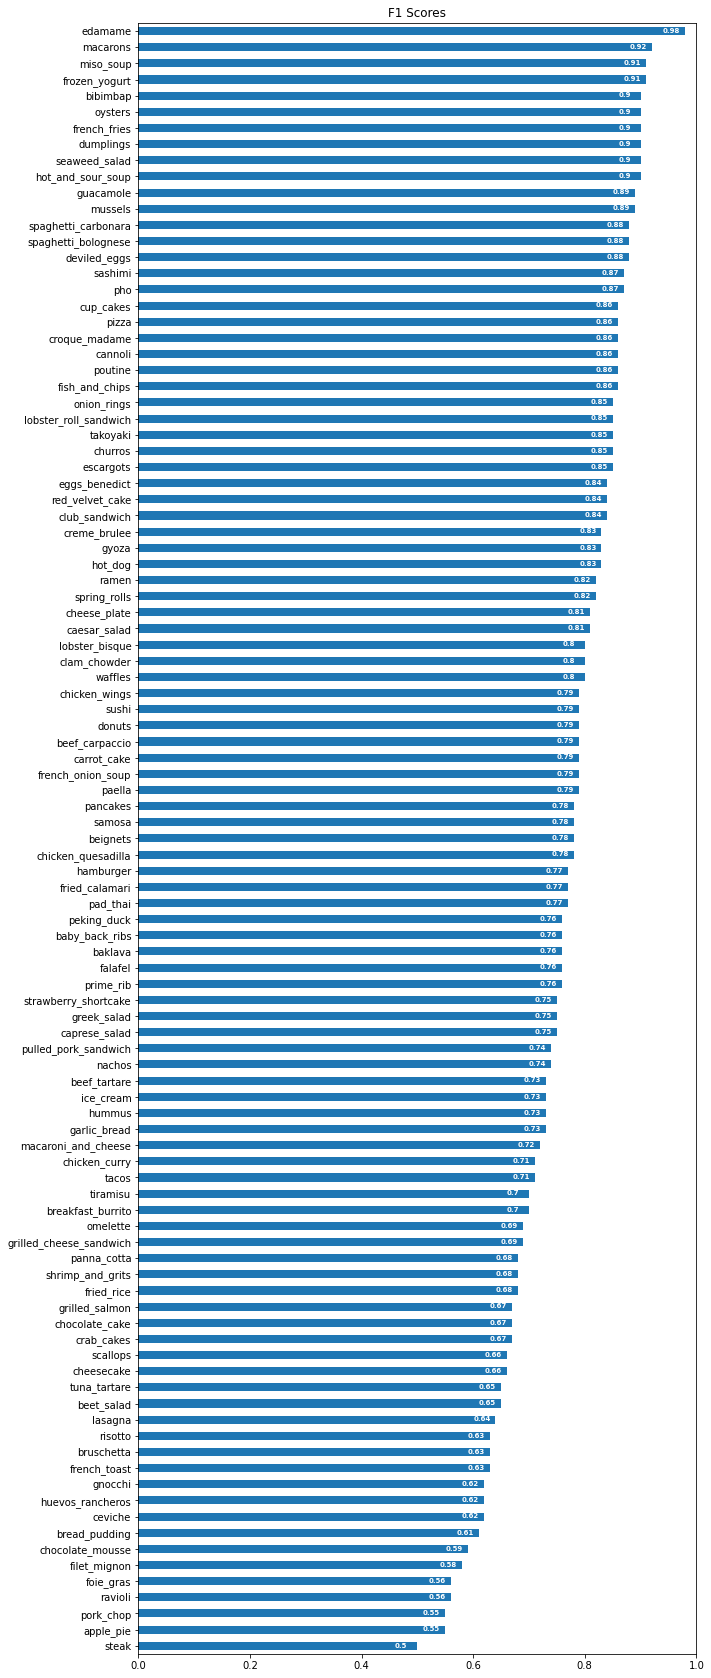

In [52]:
ax = f1_scores.plot.barh(title='F1 Scores', xlim=(0., 1.), figsize=(10, 30))
for i, v in enumerate(f1_scores):
    ax.text(v - 0.04, i - 0.1, str(v), color='white', fontweight='bold', fontsize=7)

Let's see some most wrong predictions

In [53]:
wrong_imgs = []
wrong_y_test = []
wrong_y_pred = []
confidents = []
 
# choose wrong preds with 70%+ confident
for img, label in test_data.unbatch():
  label = label.numpy()
  pred = model.predict(tf.expand_dims(img, axis=0)).squeeze()
  pred_label = tf.argmax(pred, axis=0).numpy()
  conf = pred[pred_label]
  if label != pred_label and conf >= 0.70:
    wrong_imgs.append(img)
    wrong_y_test.append(label)
    wrong_y_pred.append(pred)
    confidents.append(conf)

wrong_imgs = np.array(wrong_imgs)

wrong_pred = pd.DataFrame({
    'y_test' : wrong_y_test,
    'y_pred' : wrong_y_pred,
    'confident' : confidents,
}).sort_values(by='confident', ascending=False)

In [54]:
len(wrong_pred)

1570

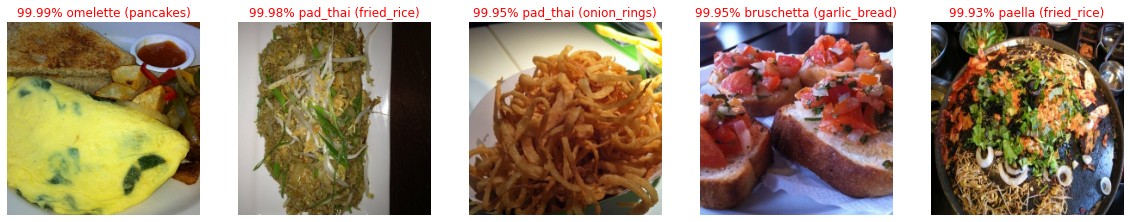

In [62]:
# plot top 5 wrong predicted images
utils.plot_pred_images(wrong_imgs[wrong_pred.index[:5], :, :, :].astype('uint8'),
                       wrong_pred.y_pred[:5],
                       wrong_pred.y_test[:5],
                       class_names=class_names)

From this figure, we can say most of the wrong predicted pictures were not clear to make good predictions. However, we are good to go.